# Механика TensorFlow

В ранней версии низкоуровневого АРI-интерфейса TensorFlow (vl) граф
должен был объявляться явно.

1. Создать новый пустой вычислительный граф.
2. Добавить в вычислительный граф узлы (тензоры и операции).
3. Провести оценку (выполнить) граф:
    1) начать новый сеанс;
    2) инициализировать переменные в графе;
    3) запустить вычислительный граф в этом сеансе. 


In [1]:
import tensorflow as tf

g = tf.Graph()
with g.as_default():
    a = tf.constant(1, name='a')
    b = tf.constant(2, name='b')
    c = tf.constant(3, name='c')
    z = 2*(a-b) + c

with tf.compat.v1.Session(graph=g) as sess:
    print('z=', sess.run(z))

z= 1


В TensorFlow v 1.х сеанс представляет собой среду, в которой могут выполняться операции и тензоры графа.

### Загрузка входных данных в модель (TF v1)

Еще одно важное усовершенствование версии TensorFlow v2 по сравнению с TensorFlow v1 .х касается того, каким образом можно загружать данные в модели. В TensorFlow v2 мы можем напрямую подавать данные в
форме переменных Python или массивов NumPy. Тем не менее, когда применяется низкоуровневый АРI-интерфейс TensorFlow v1, необходимо создавать переменные-заполнители для снабжения модели входными данными.

In [2]:
g = tf.Graph()
with g.as_default():
    a = tf.compat.v1.placeholder(shape=None,
                                 dtype=tf.int32, name='tf_a')
    b = tf.compat.v1.placeholder(shape=None,
                                 dtype=tf.int32, name='tf_b')
    c = tf.compat.v1.placeholder(shape=None,
                                 dtype=tf.int32, name='tf_c')
    z = 2*(a-b) + c

with tf.compat.v1.Session(graph=g) as sess:
    feed_dict = {a: 1, b: 2, c: 3}
    print('z=', sess.run(z, feed_dict=feed_dict))

z= 1


TensorFlow v2 предлагается инструмент под названием AutoGraph, который способен автоматически трансформировать код
Python в код графов TensorFlow для более быстрого выполнения. Вдобавок
в TensorFlow предоставляется простой механизм для компиляции обычной
функции Python в статический граф TensorFlow с тем, чтобы сделать вычисления более эффективными.tf.subtract(a, b)

In [3]:
@tf.function
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z
tf.print('scalar input:', compute_z(1, 2, 3))
tf.print('rank 1 input:', compute_z([1], [2], [3]))

scalar input: 1
rank 1 input: [1]


После вызова декорированной функции TensorFlow проверит, не был
ли граф с соответствующим ключом сгенерирован ранее. Если граф такого
рода не существует, тогда TensorFlow сгенерирует новый граф и сохранит
новый ключ. С другой стороны, если мы хотим ввести ограничения на способ вызова функции, то при ее определении можем указать входную сигнатуру посредством кортежа из объектов tf.TensorSpec.

In [4]:
# разрешены тензоры ранга 1 типа tf.int32
@tf.function(input_signature=(tf.TensorSpec(shape=[None],
                                            dtype=tf.int32),
                              tf.TensorSpec(shape=[None],
                                            dtype=tf.int32),
                              tf.TensorSpec(shape=[None],
                                            dtype=tf.int32)))
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z
tf.print('rank 1 input:', compute_z([1], [2], [3]))
tf.print('rank 1 input:', compute_z([1, 2], [3, 4], [5, 6]))

rank 1 input: [1]
rank 1 input: [1 2]


In [5]:
try:
    tf.print('scalar input:', compute_z(1, 2, 3))
except:
    print('error')

error


### Объекты VariaЬle библиотеки Tensorflow для хранения и обновления параметров модели 

В контексте TensorFlow объект
Variabe представляет собой особый объект Tensor, который позволяет сохранять и обновлять параметры моделей во время обучения. 

In [6]:
a = tf.Variable(initial_value=3.14, name='var_a')
print(a)

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.14>


Переменные имеют атрибут по имени trainable, который по умолчанию установлен в True. 


In [7]:
w = tf.Variable([1, 2, 3])
w.trainable

True

In [8]:
w.assign([3, 1, 4], read_value=True)

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([3, 1, 4])>

In [9]:
w.assign_add([2, -1, 2], read_value=False)

In [10]:
w.value()

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([5, 0, 6])>

Когда аргумент read_value установлен в True (что принято по умолчанию), эти операции будут автоматически возвращать новые значения после
обновления текущих значений объекта Variable. Установка read_value в
False подавляет автоматический возврат обновленного значения (но объект
Variаblе по-прежнему будет обновляться на месте). Вызов w.value()
будет возвращать значения в формате тензора.

In [11]:
# случайная инициализация весов
tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal()
tf.print(init(shape=(3,)))

[-0.722795904 1.01456821 0.251808226]


In [12]:
v = tf.Variable(init(shape=(2, 3)))
tf.print(v)

[[0.28982234 -0.782292843 -0.0453658961]
 [0.960991383 -0.120003454 0.708528221]]


#### Инициализация Ксавье (или Глоро) 

На ранней стадии развития ГО путем наблюдений выяснилось, что инициализация весов со случайным равномерным или случайным нормальным распределением часто могла приводить к низкой эффективности модели во время обучения.
В 2010 году Глоро и Бенджи исследовали влияние инициализации
и предложили новаторскую более надежную схему инициализации,
облегчающую обучение глубоких нейронных сетей. Основная идея
инициализации Ксавье заключается в том, чтобы приблизительно
уравновесить дисперсию градиентов между разными слоями. В противном случае во время обучения некоторые слои могут получить
слишком много внимания, тогда как другие слои будут отставать.
Согласно научной статье Глоро и Бенджи, если мы хотим инициализировать веса значениями с равномерным распределением, то должны выбирать интервал равномерного распределения следующим образом:

<img src="pic/gloro.png"/>

Здесь n<sub>вх</sub> - количество входных нейронов, умноженных на веса, а
n<sub>вых</sub> - количество выходных нейронов, которые передают значения
следующему слою. Для инициализации весов значениями с гауссовым (нормальным) распределением рекомендуется выбирать стандартное отклонение:

<img src="pic/gloro_std.png"/>

In [13]:
# tf.Module
class MyModule(tf.Module):
    def __init__(self):
        init = tf.keras.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2, 3)),
                              trainable=True)
        self.w2 = tf.Variable(init(shape=(1, 2)),
                              trainable=False)

m = MyModule()
print('all var module: ', [v.shape for v in m.variables])
print('trainable var module: ', [v.shape for v in m.trainable_variables])

all var module:  [TensorShape([2, 3]), TensorShape([1, 2])]
trainable var module:  [TensorShape([2, 3])]


### Расчет градиентов посредством автоматического дифференцирования и GradientTape

Библиотека TensorFlow поддерживает автоматическое дифференцирование, которое можно трактовать как реализацию цепного правила для
расчета градиентов вложенных функций. Когда мы определяем последовательность операций, которая в результате дает какой-то выход или даже
промежуточные тензоры, TensorFlow обеспечивает контекст для расчета градиентов таких вычислительных тензоров относительно их зависимых углов в вычислительном графе.

In [14]:
# z = w*x + b
# loss = (y - z)^2

w = tf.Variable(1.0)
b = tf.Variable(0.0)
print(w.trainable, b.trainable)

x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])
with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
tf.print('dL/dw:', dloss_dw)

True True
dL/dw: -1.9599998


In [15]:
# проверка градиента
tf.print(2*x*(w*x+b-y))

[-1.9599998]


Класс tf.GradientTape автоматически поддерживает градиенты
для обучаемых переменных. Тем не менее, для отслеживания необучаемых переменных и других объектов Tensor необходимо добавить к GradientTape дополнительную модификацию вида tape.watch()

In [16]:
# dloss/dx
with tf.GradientTape() as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dx = tape.gradient(loss, x)
tf.print('dL/dx:', dloss_dx)

dL/dx: [-1.39999986]


Когда мы отслеживаем вычисления в контексте tf.GradientTape, лента по умолчанию будет сохранять ресурсы только для одиночного расчета
градиентов. Например, после однократного вызова tape.gradient () ресурсы будут освобождены и лента очистится. Следовательно, если мы хотим рассчитать более одного градиента, тогда понадобится сделать ленту постоянной:

In [17]:
# dloss/dw и dloss/dx
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
tf.print('dL/dw:', dloss_dw)

dloss_db = tape.gradient(loss, b)
tf.print('dL/db:', dloss_db)

dL/dw: -1.9599998
dL/db: -1.39999986


Если мы вычисляем градиенты члена потери относительно параметров модели, то можем определить оптимизатор и применить градиенты для оптимизации параметров модели с использованием АРI-интерфейса tf.keras:

In [18]:
optimizer = tf.keras.optimizers.SGD()
optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))
tf.print('updated w:', w)
tf.print('updated b:', b)

updated w: 1.0196
updated b: 0.0139999986


### Упрощение реализаций распространенных архитектур посредством API-интерфейса Keras

In [19]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.build(input_shape=(None, 4))  # позднее создание переменных
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


В вызове model.build () мы указали форму входа, создавая переменные после определения модели для этой конкретной формы, а также отобразили количество параметров каждого слоя: 16 * 4 + 16 = 80 для первого
слоя и 16 * 32 + 32 = 544 для второго слоя. После того как переменные (или
параметры модели) созданы, мы можем получать доступ к обучаемым и необучаемым переменным. 

In [20]:
[print("{:20s}".format(v.name), v.trainable, v.shape)
 for v in model.variables]

dense/kernel:0       True (4, 16)
dense/bias:0         True (16,)
dense_1/kernel:0     True (16, 32)
dense_1/bias:0       True (32,)


[None, None, None, None]

Конфигурирование слоев:

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(
          units=16,
          activation=tf.keras.activations.relu,
          kernel_initializer=tf.keras.initializers.glorot_uniform(),
          bias_initializer=tf.keras.initializers.Constant(2.0)))
model.add(tf.keras.layers.Dense(
          units=32,
          activation=tf.keras.activations.sigmoid,
          kernel_initializer=tf.keras.regularizers.l1))

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()])

### Решение задачи классификации XOR

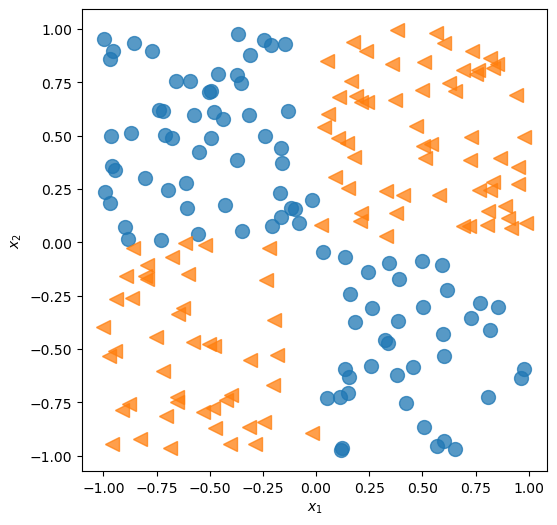

In [1]:
# генерация данных
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0

x_train = x[:100, :]
y_train = y[:100]

x_valid = x[100:, :]
y_valid = y[100:]

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0],
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0],
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1,
                                input_shape=(2,),
                                activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200,
                 batch_size=2,
                 verbose=0)

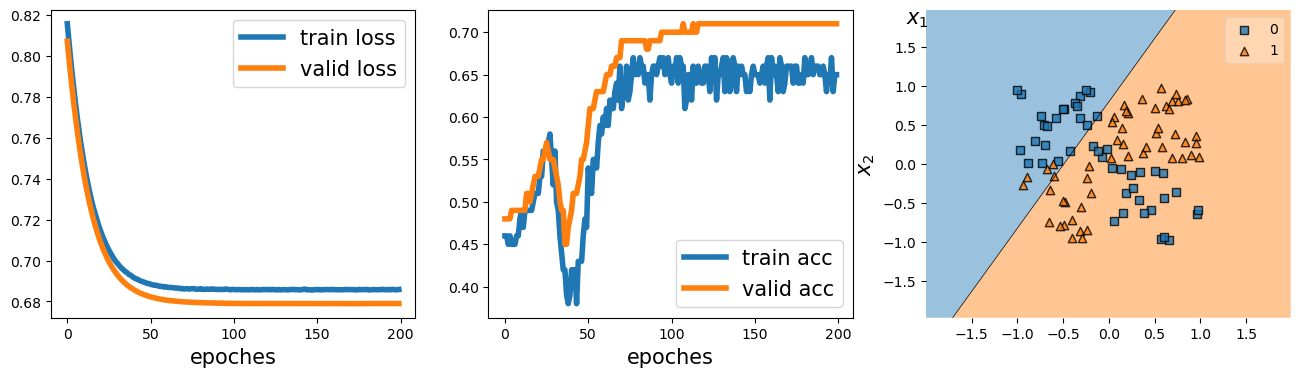

In [25]:
from mlxtend.plotting import plot_decision_regions

history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['train loss', 'valid loss'], fontsize=15)
ax.set_xlabel('epoches', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['train acc', 'valid acc'], fontsize=15)
ax.set_xlabel('epoches', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.int32),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025) 
ax.set_ylabel(r'$x_2$', size=15)
ax.xaxis.set_label_coords(-0.025, 1) 
plt.show()

Простая модель без скрытых слоев может получить только
линейную границу решений , которая не способна решить задачу XOR. Как
следствие, мы наблюдаем, что член потери для обучающего и проверочного наборов данных очень высок, а правильность классификации крайне низка.

Чтобы вывести нелинейную границу решений, мы можем добавить один
и более скрытых слоев, связанных с помощью нелинейных функций активации. Теорема об универсальной аппроксимации утверждает, что нейронная
сеть прямого распространения с единственным скрытым слоем и относительно большим количеством скрытых элементов способна относительно
хорошо аппроксимировать произвольные непрерывные функции. Таким образом, один из подходов к получению более приемлемого решения задачи
XOR предусматривает добавление скрытого слоя и сравнение различных количеств скрытых элементов. Добавление дополнительных элементов соответствует увеличению ширины слоя.

Альтернативно можно добавить дополнительные скрытые слои, что сделает модель глубже. Преимущество более глубокой, а не более широкой нейронной сети заключается в том, что для достижения сопоставимой емкости модели требуется меньше параметров. Но недостаток глубоких моделей связан с тем, что глубокие модели предраспаложены к исчезновению и взрывному росту градиентов, из-за чего их обучение становится труднее.

In [26]:
tf.random.set_seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,),
                                activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200,
                 batch_size=2,
                 verbose=0)

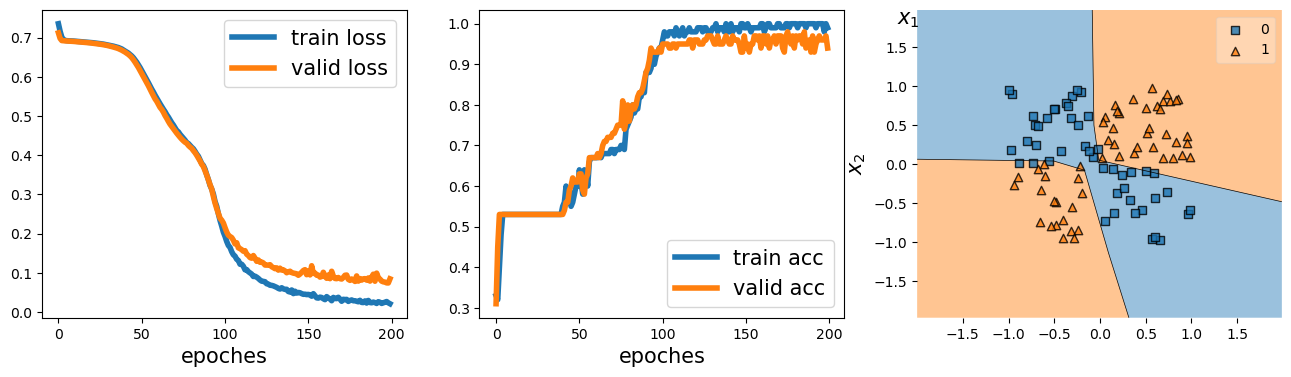

In [28]:
from mlxtend.plotting import plot_decision_regions

history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['train loss', 'valid loss'], fontsize=15)
ax.set_xlabel('epoches', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['train acc', 'valid acc'], fontsize=15)
ax.set_xlabel('epoches', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.int32),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025) 
ax.set_ylabel(r'$x_2$', size=15)
ax.xaxis.set_label_coords(-0.025, 1) 
plt.show()

In [29]:
model.evaluate(x_valid, y_valid)

4/4 [==============================] - 0s 4ms/step - loss: 0.0845 - binary_accuracy: 0.9400


[0.08453187346458435, 0.9399999976158142]

Теперь мы видим, что модель в состоянии вывести нелинейную границу
решений для имеющихся данных, достигая 100%-ной правильности на обучающем наборе. Правильность на проверочном наборе составляет 94%, что
говорит о небольшой степени переобучения модели. 

### Функциональный API-интерфейс Keras

Функциональный API позволяет создавать более сложные модели, которые могут иметь множественный вход, выход или промежуточные ветви.

In [2]:
# реализация Sequential
tf.random.set_seed(1)

inputs = tf.keras.Input(shape=(2,))

h1 = tf.keras.layers.Dense(units=4, activation='relu')(inputs)
h2 = tf.keras.layers.Dense(units=4, activation='relu')(h1)
h3 = tf.keras.layers.Dense(units=4, activation='relu')(h2)

outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(h3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [3]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=50,
                 batch_size=2,
                 verbose=0)

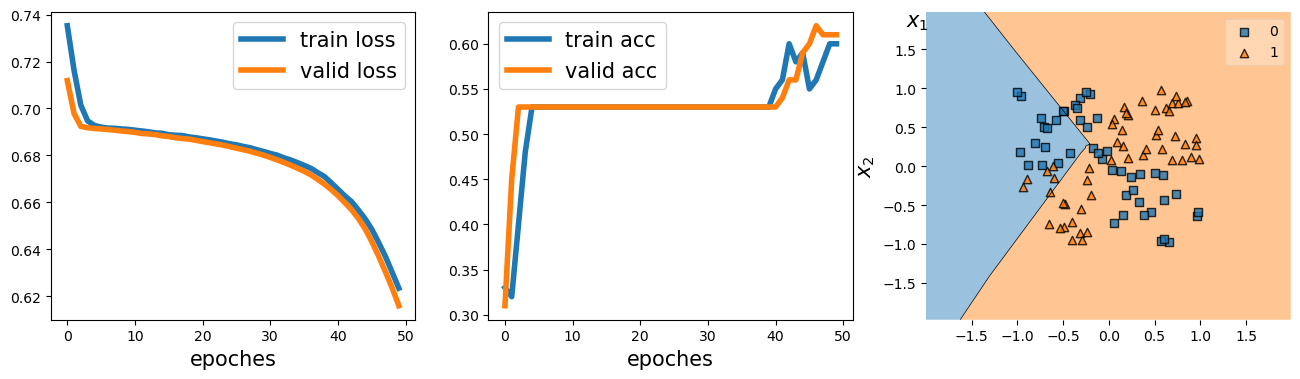

In [4]:
from mlxtend.plotting import plot_decision_regions

history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['train loss', 'valid loss'], fontsize=15)
ax.set_xlabel('epoches', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['train acc', 'valid acc'], fontsize=15)
ax.set_xlabel('epoches', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.int32),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025) 
ax.set_ylabel(r'$x_2$', size=15)
ax.xaxis.set_label_coords(-0.025, 1) 
plt.show()

### Реализация моделей на основе класса Model (Keras)

In [10]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = tf.keras.layers.Dense(
            units=4, activation='relu')
        self.hidden_2 = tf.keras.layers.Dense(
            units=4, activation='relu')
        self.hidden_3 = tf.keras.layers.Dense(
            units=4, activation='relu')
        self.output_layer = tf.keras.layers.Dense(
            units=1, activation='sigmoid')

    def call(self, inputs):
        h = self.hidden_1(inputs)
        h = self.hidden_2(h)
        h = self.hidden_3(h)
        return self.output_layer(h)

In [11]:
tf.random.set_seed(1)

model = MyModel()
model.build(input_shape=(None, 2))
model.summary()

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=50,
                 batch_size=2,
                 verbose=0)

Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             multiple                  12        
_________________________________________________________________
dense_17 (Dense)             multiple                  20        
_________________________________________________________________
dense_18 (Dense)             multiple                  20        
_________________________________________________________________
dense_19 (Dense)             multiple                  5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [15]:
hist.history['binary_accuracy'][-1]

0.6000000238418579

### Реализация специальных слоев Keras

In [16]:
# реализация слоя w(x+e)+b, e - случайный шум
class NoisyLinear(tf.keras.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev
        super(NoisyLinear, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(name='weights',
                                 shape=(input_shape[1], self.output_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.output_dim,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs, training=False):
        if training:
            batch = tf.shape(inputs)[0]
            dim = tf.shape(inputs)[1]
            noise = tf.random.normal(shape=(batch, dim),
                                     mean=0.0,
                                     stddev=self.noise_stddev)
            noisy_inputs = tf.add(inputs, noise)
        else:
            noisy_inputs = inputs
        z = tf.matmul(noisy_inputs, self.w) + self.b
        return tf.keras.activations.relu(z)

    def get_config(self):
        config = super(NoisyLinear, self).get_config()
        config.update({'output_dim': self.output_dim,
                       'noise_stddev': self.noise_stddev})
        return config

In [17]:
tf.random.set_seed(1)

noisy_layer = NoisyLinear(4)
noisy_layer.build(input_shape=(1, 4))
tf.print(noisy_layer(x, training=True))

[[0.00996803679 0.0017295673 0 0]
 [0 0.0622812733 0.021442527 0]
 [0 0.0542469099 0.0294852406 0]
 ...
 [0.0294949152 0 0 0]
 [0.0194668248 0 0 0]
 [0 0.0018813794 0 0]]


In [18]:
# реконструкция из config
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
tf.print(new_layer(x, training=True))

[[0 0.016262887 0 0]
 [0 0 0.0620713234 0.0115114348]
 [0 0 0.0901583582 0.0428460762]
 ...
 [0.00681168074 0.0189800821 0 0]
 [0 0.0179935303 0 0]
 [0 0.00380158052 0 0]]


In [19]:
tf.random.set_seed(1)

model = tf.keras.Sequential([
    NoisyLinear(4, noise_stddev=0.1),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

model.build(input_shape=(None, 2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noisy_linear_1 (NoisyLinear) (None, 4)                 12        
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=50,
                 batch_size=2,
                 verbose=0)

In [21]:
hist.history['binary_accuracy'][-1]

0.6600000262260437

### Оценщики Tensorflow

В АРI-интерфейсе tf.estimator инкапсулируются внутренние шаги задач МО, такие как обучение, прогнозирование (выведение) и оценка. Оценщики более инкапсулированы (т.е. защищены от внешнего вмешательства), но и более масштабируемы в сравнении с предшествующими подходами.
К тому же АРI-интерфейс tf.estimator добавляет поддержку для прогона моделей на множестве платформ, не требуя внесения в код крупных изменений, что делает их более подходящими для так называемой "производственной стадии" в индустриальных приложениях. 

Датасет Auto MPG - является общим эталонным набором данных МО для прогнозирования эффективности расхода топлива автомобилем в милях на галлон (miles реr gallon): 

In [ ]:
import pandas as pd

dataset_path = tf.keras.utils.get_file(
    './auto-mpg.data',
    ('https://archive.ics.uci.edu/ml/'
     'machine-learning-databases/auto-mpg/auto-mpg.data'))

In [ ]:
column_names = ['MPG', 'Cylinders', 'Displacement',
                'Horsepower', 'Weight', 'Acceleration',
                'ModelYear', 'Origin']

In [ ]:
df = pd.read_csv(dataset_path, names=column_names,
                 na_values='?', comment='\t',
                 sep=' ', skipinitialspace=True)

In [ ]:
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [ ]:
df.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
ModelYear       0
Origin          0
dtype: int64

In [ ]:
# удаление путсых строк
df = df.dropna()
df = df.reset_index(drop=True)
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [ ]:
# train test split
import sklearn
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size=0.8)
train_stats = df_train.describe().transpose()

numeric_column_names = ['Cylinders', 'Displacement',
                        'Horsepower', 'Weight', 'Acceleration']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()
for col_name in numeric_column_names:
    mean = train_stats.loc[col_name, 'mean']
    std = train_stats.loc[col_name, 'std']
    df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name]-mean)/std
    df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name]-mean)/std

In [ ]:
df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
299,34.2,-0.836182,-0.837172,-0.890427,-0.906475,-0.902880,79,1
283,17.0,1.532370,1.115943,0.736090,1.084095,-0.094503,79,1
211,13.0,1.532370,1.555393,1.142719,1.345054,-1.343814,76,1
176,23.0,-0.836182,-0.690688,-0.402472,0.012343,0.493409,75,2
199,18.5,0.348094,0.578836,0.193918,0.847412,0.199453,76,1


df_train_norm, df_test_norm содержат пять столбцов образующих непрерывные признаки.

Теперь, используя feature_column.numeric_column, трансформируем непрерывные признаки в структуру данных под названием столбец признаков, с которой могут работать оценщики Tensorflow.

In [ ]:
numeric_features = []
for col_name in numeric_column_names:
    numeric_features.append(tf.feature_column.numeric_column(key=col_name))

In [ ]:
numeric_features

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

Сгруппируем информацию о годах выпуска по следующему правилу:
<img src="pic/14_feature.png"/>

In [ ]:
feature_year = tf.feature_column.numeric_column(key='ModelYear')
bucketized_features = []
bucketized_features.append(tf.feature_column.bucketized_column(
    source_column=feature_year, boundaries=[73, 76, 79]))

In [ ]:
bucketized_features

[BucketizedColumn(source_column=NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(73, 76, 79))]

Далее определим неупорядоченный категориальный призна Origin (US, Europe, Japan)

In [ ]:
feature_origin = tf.feature_column.categorical_column_with_vocabulary_list(
    key='Origin',
    vocabulary_list=[1, 2, 3])

Определенные оценщики, такие как DNNClassifier и DNNRegressor,
принимают только то, что называется "плотными столбцами". По этой
причине следующим шагом будет преобразование существующего столбца категориального признака в плотный столбец подобного рода, для чего
существуют два способа: использование столбца вложений посредством
embedding_column или столбца индикаторов через indicator_column.

Столбец индикаторов преобразует категориальные индексы в векторы в унитарном коде, т.е. индекс 0 будет закодирован как [1, 0, 0], индекс 1 - как
[0, 1, 0] и т.д. 

С другой стороны, столбец вложений отображает каждый индекс на вектор случайных чисел типа float, который может быть обучен.

In [ ]:
categorical_indicator_features = []
categorical_indicator_features.append(
    tf.feature_column.indicator_column(feature_origin))

#### МО с использованием готовых оценщиков

Работа с готовыми оценщиками может быть представлена в виде 4 шагов:
1. Определить входную функцию для загрузки данных.
2. Преобразовать набор данных в столбцы признаков.
3. Создать объект оценщика (применяя готовый оценщик или создавая новый путем преобразования модели Keras в оценщик).
4. Использовать методы оценщика train (), evaluate () и predict (). 

In [ ]:
# 1
def train_input_fn(df_train, batch_size=8):
    df = df_train.copy()
    train_x, train_y = df, df.pop('MPG')
    dataset = tf.data.Dataset.from_tensor_slices((dict(train_x), train_y))

    # тасование, повторение, разбиение на пакеты образцов
    return dataset.shuffle(1000).repeat().batch(batch_size)

In [ ]:
ds = train_input_fn(df_train_norm)
batch = next(iter(ds))
print('keys:', batch[0].keys())
print('batch with years:', batch[0]['ModelYear'])

keys: dict_keys(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'ModelYear', 'Origin'])
batch with years: tf.Tensor([80 80 78 76 75 78 71 76], shape=(8,), dtype=int64)


In [ ]:
# функция для испытательного набора
def eval_input_fn(df_test, batch_size=8):
    df = df_test.copy()
    test_x, test_y = df, df.pop('MPG')
    dataset = tf.data.Dataset.from_tensor_slices((dict(test_x), test_y))

    return dataset.batch(batch_size)

In [ ]:
# 2 - определение столбцов признаков
all_feature_columns = (numeric_features + bucketized_features +
                       categorical_indicator_features)

Для третьего шага нам необходимо создать новый объект оценщика.
Поскольку прогнозирование значений MPG является типичной задачей регрессии, мы будем применять класс tf.estirnator.DNNRegressor. При
создании объекта регрессионного оценщика мы предоставим список столбцов признаков и укажем количество скрытых элементов, которые желаем
иметь в каждом скрытом слое, используя аргумент hidden_units.

In [ ]:
# 3
regressor = tf.estimator.DNNRegressor(
    feature_columns=all_feature_columns,
    hidden_units=[32, 10],
    model_dir='models/autompg-dnnregressor/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/autompg-dnnregressor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Дополнительно предоставленный аргумент model_dir указывает каталог для сохранения параметров модели. Одно из преимуществ оценщиков
заключается в том, что во время обучения они автоматически сохраняют
контрольные точки модели.

После пройденных трех базовых шагов мы можем задействовать оценщик для обучения, оценки и в итоге прогнозирования. Регрессор можно
обучить вызовом метода train(), для которого требовалась ранее определенная входная функция: 

In [ ]:
EPOCHS = 1000
BATCH_SIZE = 8
total_steps = EPOCHS * int(np.ceil(len(df_train) / BATCH_SIZE))
print('Steps train:', total_steps)

Steps train: 40000


In [ ]:
regressor.train(
    input_fn=lambda: train_input_fn(df_train_norm, batch_size=BATCH_SIZE),
    steps=total_steps)

In [ ]:
610